###1. Install dependencies and fetch repository

In [ ]:
%pip install jax flax optax
%pip install numpy tensorflow matplotlib ml_collections

     |████████████████████████████████| 184 kB 31.0 MB/s 
     |████████████████████████████████| 140 kB 59.6 MB/s 
     |████████████████████████████████| 72 kB 868 kB/s 
     |████████████████████████████████| 77 kB 7.4 MB/s 
     |████████████████████████████████| 462 kB 71.0 MB/s 
  Created wheel for ml-collections: filename=ml_collections-0.1.1-py3-none-any.whl size=94524 sha256=e74b31e0e3783b2eb6f203e22086155ff92f7f6782ab1d4a17a0d83802eddb76
  Stored in directory: /root/.cache/pip/wheels/b7/da/64/33c926a1b10ff19791081b705879561b715a8341a856a3bbd2
Successfully built ml-collections


In [ ]:
%env XLA_PYTHON_CLIENT_PREALLOCATE=false
%env XLA_PYTHON_CLIENT_ALLOCATOR=platform

env: XLA_PYTHON_CLIENT_PREALLOCATE=false
env: XLA_PYTHON_CLIENT_ALLOCATOR=platform


In [ ]:
!git clone https://github.com/YES-ai/super-resolution.git

Cloning into 'super-resolution'...
remote: Enumerating objects: 82, done.
remote: Counting objects: 100% (82/82), done.
remote: Compressing objects: 100% (72/72), done.
remote: Total 82 (delta 13), reused 75 (delta 6), pack-reused 0
Unpacking objects: 100% (82/82), done.


In [ ]:
%cd super-resolution
%ls

/content/super-resolution
data/             maskgit/                               README.md
dataset_utils.py  pretrained_vqgan_reconstruction.ipynb  SRMaskGIT.ipynb


###2. Import libraries

In [ ]:
import os
import io
import flax
import functools
import itertools
import jax
import jax.numpy as jnp
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from PIL import ImageFilter, Image
import requests
import cv2
from skimage.metrics import structural_similarity as ssim

import maskgit
from maskgit.utils import visualize_images, read_image_from_url, restore_from_path, draw_image_with_bbox, Bbox
from maskgit.inference import ImageNet_class_conditional_generator
from maskgit.nets import vqgan_tokenizer, maskgit_transformer
from maskgit.configs import maskgit_class_cond_config
from maskgit.libml import parallel_decode

###3. Prepare the Dataset for training

In [ ]:
!wget https://storage.googleapis.com/yy3185/DIV2K_train_HR.zip
!wget https://storage.googleapis.com/yy3185/DIV2K_valid_HR.zip

--2022-04-21 03:58:55--  https://storage.googleapis.com/yy3185/DIV2K_train_HR.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.10.128, 142.251.12.128, 172.217.194.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.10.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3982211018 (3.7G) [application/zip]
Saving to: ‘DIV2K_train_HR.zip’

DIV2K_train_HR.zip  100%[===================>]   3.71G  47.6MB/s    in 96s     

2022-04-21 04:00:31 (39.7 MB/s) - ‘DIV2K_train_HR.zip’ saved [3982211018/3982211018]

--2022-04-21 04:00:31--  https://storage.googleapis.com/yy3185/DIV2K_valid_HR.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.128, 142.251.10.128, 142.251.12.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 448993893 (428M) [application/zip]
Saving to: ‘DIV2K_valid_HR.zip’

DIV2K

In [ ]:
%mkdir DIV2K_train_HR
%mv DIV2K_train_HR.zip DIV2K_train_HR/
%mkdir DIV2K_valid_HR
%mv DIV2K_valid_HR.zip DIV2K_valid_HR/
!unzip -q DIV2K_train_HR/DIV2K_train_HR.zip
!rm DIV2K_train_HR/DIV2K_train_HR.zip
!unzip -q DIV2K_valid_HR/DIV2K_valid_HR.zip
!rm DIV2K_valid_HR/DIV2K_valid_HR.zip

In [ ]:
import dataset_utils
div2k_train_dataset = dataset_utils.ImageDataset(root="./DIV2K_train_HR", normalize=False)
div2k_val_dataset = dataset_utils.ImageDataset(root="./DIV2K_valid_HR", normalize=False)

In [ ]:
from torch.utils.data import DataLoader
# batch_size = generator_512.maskgit_cf.eval_batch_size
batch_size = 2
# train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
train_loader = DataLoader(div2k_train_dataset, batch_size=batch_size, shuffle=True)
# val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(div2k_val_dataset, batch_size=batch_size, shuffle=False)
len(train_loader), len(val_loader)

(450, 50)

###4. Load MaskGIT model Structure

####4a. Download pretrained models (MaskGIT Official)


In [ ]:
!mkdir -p checkpoints/

models_to_download = itertools.product( 
    *[ ["maskgit", "tokenizer"],  [512] ])

for (type_, resolution) in models_to_download:
  canonical_path = ImageNet_class_conditional_generator.checkpoint_canonical_path(type_, resolution)
  if os.path.isfile(canonical_path):
    print(f"Checkpoint for {resolution} {type_} already exists, not downloading again")
  else:
    source_url = f'https://storage.googleapis.com/maskgit-public/checkpoints/{type_}_imagenet{resolution}_checkpoint'
    !wget {source_url} -O {canonical_path}

--2022-04-21 04:01:20--  https://storage.googleapis.com/maskgit-public/checkpoints/maskgit_imagenet512_checkpoint
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.200.128, 74.125.68.128, 74.125.24.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.200.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 692202904 (660M) [application/octet-stream]
Saving to: ‘./checkpoints/maskgit_imagenet512_checkpoint’

./checkpoints/maskg 100%[===================>] 660.14M  41.0MB/s    in 18s     

2022-04-21 04:01:39 (37.2 MB/s) - ‘./checkpoints/maskgit_imagenet512_checkpoint’ saved [692202904/692202904]

--2022-04-21 04:01:39--  https://storage.googleapis.com/maskgit-public/checkpoints/tokenizer_imagenet512_checkpoint
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.130.128, 74.125.68.128, 74.125.24.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.130.128|:443... connected.
HTTP re

####4b. Download our finetuned models

Finetuned maskgit parameters

In [ ]:
maskgit_params_name = "sr_maskgit_params_epoch28"
source_url = f"https://storage.googleapis.com/sr_maskgit_checkpoint_storage/{maskgit_params_name}"
!wget -P './checkpoints' {source_url}

--2022-04-21 04:01:48--  https://storage.googleapis.com/sr_maskgit_checkpoint_storage/sr_maskgit_params_epoch28
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.194.128, 74.125.200.128, 74.125.68.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.194.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 692202904 (660M) [application/octet-stream]
Saving to: ‘./checkpoints/sr_maskgit_params_epoch28’

sr_maskgit_params_e 100%[===================>] 660.14M  42.8MB/s    in 16s     

2022-04-21 04:02:05 (41.2 MB/s) - ‘./checkpoints/sr_maskgit_params_epoch28’ saved [692202904/692202904]



Download model optimzer state (Needed only for training)

In [ ]:
optimizer_name = "sr_optim_epoch28"
source_url = f" https://storage.googleapis.com/sr_maskgit_checkpoint_storage/{optimizer_name}"
!wget {source_url}

--2022-04-21 04:02:05--  https://storage.googleapis.com/sr_maskgit_checkpoint_storage/sr_optim_epoch28
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.130.128, 74.125.68.128, 74.125.24.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.130.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1384412978 (1.3G) [application/octet-stream]
Saving to: ‘sr_optim_epoch28’

sr_optim_epoch28    100%[===================>]   1.29G  53.1MB/s    in 29s     

2022-04-21 04:02:36 (45.3 MB/s) - ‘sr_optim_epoch28’ saved [1384412978/1384412978]



#### 4c. Initialize Models

In [ ]:
epoch = 28
tokenizer_name = "tokenizer_imagenet512_checkpoint"
TRANSFORMER_MODEL_PATH = f"/content/super-resolution/checkpoints/sr_maskgit_params_epoch{epoch}"
TOKENIZER_MODEL_PATH = f"/content/super-resolution/checkpoints/{tokenizer_name}"

maskgit_cf = maskgit_class_cond_config.get_config()
maskgit_cf.image_size = 512
maskgit_cf.eval_batch_size = 8
transformer_latent_size = maskgit_cf.image_size // maskgit_cf.transformer.patch_size
transformer_block_size = transformer_latent_size ** 2 + 1

def build_vqvae():
  return vqgan_tokenizer.VQVAE(config=maskgit_cf, dtype=jnp.float32, train=False)

def build_maskgit():
  return maskgit_transformer.Transformer(
    vocab_size=maskgit_cf.vqvae.codebook_size + maskgit_cf.num_class + 1,
    hidden_size=maskgit_cf.transformer.num_embeds,
    num_hidden_layers=maskgit_cf.transformer.num_layers,
    num_attention_heads=maskgit_cf.transformer.num_heads,
    intermediate_size=maskgit_cf.transformer.intermediate_size,
    hidden_dropout_prob=maskgit_cf.transformer.dropout_rate,
    attention_probs_dropout_prob=maskgit_cf.transformer.dropout_rate,
    max_position_embeddings=transformer_block_size,
  )

codebook_size = maskgit_cf.vqvae.codebook_size
mask_token = maskgit_cf.transformer.mask_token_id

vqvae = build_vqvae()
vqvae_params = restore_from_path(TOKENIZER_MODEL_PATH) # parameters for vqvae
maskgit = build_maskgit()
maskgit_params = restore_from_path(TRANSFORMER_MODEL_PATH) # parameters for MaskGIT

###[Deprecated] Modified decoding approach for our task

In [ ]:

@flax.struct.dataclass
class SRState:
  """Holds decoding state data."""
  # The position of the decoding loop in the length dimension.
  cur_index: jnp.DeviceArray  # scalar int32: current decoded length index
  # The active sequence log probabilities and finished sequence scores.
  cur_seqs: jnp.DeviceArray  # int32 [batch, seq_len]
  rng: jnp.DeviceArray  # Sampling random state.
  final_seqs: jnp.DeviceArray  # int32 [batch, num_iter, seq_len]
  decoded: jnp.DeviceArray # Marking the decoded tokens bool [batch, seq_len]


def sr_decode(inputs,
              rng,
              tokens_to_logits,
              mask_token_id=-1,
              num_iter=12,
              start_iter=0,
              choice_temperature=1.0,
              mask_scheduling_method="cosine"):
  """Fast decoding for iterative generation.

  Args:
    inputs: int32 array: [batch_size, seq_length] input sequence of masked
      tokens, where the masking tokens is defined by mask_token_id.
    rng: jnp.DeviceArray: sampling random state.
    tokens_to_logits: decoder function taking single token slices and cache and
      returning logits and updated cache.
    mask_token_id: int: [Mask] token id.
    num_iter: int: default is 12.
    start_iter: int: default is 0.
    choice_temperature: float: temperature to control the randomness of masking.
    mask_scheduling_method: masking method string. See mask_schedule.py for
      details.

  Returns:
     [batch_size, num_iter, seq_length] output sequence of tokens in all
       iterations.
  """

  inputs = inputs.astype("int32")
  total_unknown = jnp.sum(jnp.ones_like(inputs), axis=-1)

  init_state = SRState(
    cur_index=jnp.array(start_iter),
    rng=rng,
    cur_seqs=inputs,
    final_seqs=jnp.tile(jnp.expand_dims(inputs, 1), (1, num_iter, 1)),
    decoded=jnp.full(inputs.shape, False),
  )

  def loop_cond_fn(state):
    """Beam search loop termination condition."""
    not_at_end = (state.cur_index < num_iter)
    return not_at_end

  def loop_body_fn(state):
    """Beam search loop state update function."""
    print("function called")
    rng = state.rng
    step = state.cur_index
    # Current input ids: [batch_size, seq_length].
    cur_ids = state.cur_seqs
    unknown_map = (state.decoded == False)

    # Calls model on current seqs to get next-iteration seqs.
    logits = tokens_to_logits(cur_ids)
    rng, sample_rng = jax.random.split(rng, 2)
    # Samples the ids using categorical sampling: [batch_size, seq_length].
    sampled_ids = jax.random.categorical(sample_rng, logits)

    # Just updates the masked tokens.
    sampled_ids = jnp.where(unknown_map, sampled_ids, cur_ids)
    # Defines the mask ratio for the next round. The number to mask out is
    # determined by mask_ratio * total_unknown.
    ratio = 1. * (step + 1) / num_iter
    mask_ratio = mask_schedule.schedule(ratio, total_unknown, mask_scheduling_method)
    # Updates final seqs with the current sampled_ids.
    final_seqs = jax.lax.dynamic_update_slice(
        state.final_seqs, jnp.expand_dims(sampled_ids, axis=1), (0, step, 0))
    # Computes the probabilities of each selected tokens.
    probs = jax.nn.softmax(logits, axis=-1)
    selected_probs = jnp.squeeze(
        jnp.take_along_axis(probs, jnp.expand_dims(sampled_ids, -1), -1), -1)
    # Ignores the tokens given in the input by overwriting their confidence.
    selected_probs = jnp.where(unknown_map, selected_probs,
                               _CONFIDENCE_OF_KNOWN_TOKENS)
    # Gets mask lens for each sample in the batch according to the mask ratio.
    mask_len = jnp.expand_dims(
        jnp.floor(total_unknown * mask_ratio), 1)
    # Keeps at least one of prediction in this round and also masks out at least
    # one and for the next iteration
    mask_len = jnp.maximum(
        1,
        jnp.minimum(jnp.sum(unknown_map, axis=-1, keepdims=True) - 1, mask_len))

    # Adds noise for randomness
    rng, choice_rng = jax.random.split(rng)
    masking = unknown_map#mask_by_random_topk(choice_rng, mask_len, selected_probs,
                                  #choice_temperature * (1. - ratio))
    # Masks tokens with lower confidence.
    sampled_ids = sampled_ids #jnp.where(masking, mask_token_id, sampled_ids)

    return SRState(
        cur_index=state.cur_index + 1,
        cur_seqs=sampled_ids,
        rng=rng,
        final_seqs=final_seqs,
        decoded=(masking == False))

  # Run while loop and get final beam search state.
  final_state = lax.while_loop(loop_cond_fn, loop_body_fn, init_state)
  return final_state.final_seqs

###7. MaskGIT Usage Method 2

Load pretrained model.

In [ ]:
generator_512 = ImageNet_class_conditional_generator(image_size=512)

In [ ]:
arbitrary_seed = 42
rng = jax.random.PRNGKey(arbitrary_seed) 
rng, sample_rng = jax.random.split(rng)

In [ ]:
# Load one sample image
image_size = 512

img_url = 'https://storage.googleapis.com/maskgit-public/imgs/class_cond_input_1.png' # @param

hr_img = read_image_from_url(
    img_url, 
    height=image_size, 
    width=image_size)

lr_img = read_image_from_url(
    img_url, 
    height=image_size // 2, 
    width=image_size // 2)

In [ ]:
import torchvision.transforms as transforms

# [deprecated] Downsample according to given scale
def downsample_deprecated(img, scale=2) -> np.ndarray:
  h, w, _ = img.shape
  pil_img = Image.fromarray((img * 255).astype(np.uint8))
  pil_img = pil_img.resize((h//scale, w//scale), resample=PIL.Image.NEAREST)
  return np.array(pil_img) / 255.

# [deprecated] Downsample but scale back to original resolution
def downsample_with_same_shape_deprecated(img, scale=2) -> np.ndarray:
  img = np.array(downsample_deprecated(img,scale=scale))
  img = ndimage.zoom(img, zoom=(scale, scale, 1)) # may have problem here
  return img

# Downsample using torchvision transform (w/ best performance)
def ur_individual_image(image, scale=4):
  hr_height, hr_width = 512, 512
  ur_transform = []
  ur_transform.append(transforms.Resize((hr_height // scale, hr_width // scale), transforms.InterpolationMode.BICUBIC))
  ur_transform.append(transforms.Resize((hr_height, hr_width), transforms.InterpolationMode.BICUBIC))
  ur_transform.append(transforms.ToTensor())
  ur_transform = transforms.Compose(ur_transform)
  pil_img = Image.fromarray((image * 255).astype(np.uint8))
  return ur_transform(pil_img).permute(1,2,0).numpy()

Define downsample functions and apply to our image.

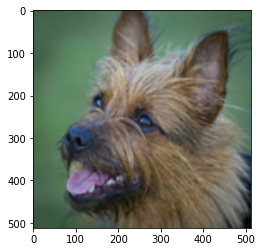

In [ ]:
plt.imshow(ur_individual_image(hr_img))

Encode the images into image tokens.

In [ ]:
def create_batch(image, batch_size=1):
    return np.repeat(image[None], batch_size, axis=0).astype(np.float32)

imgs_scale_2 = create_batch(ur_individual_image(hr_img,2))

image_tokens = generator_512.tokenizer_model.apply(
      generator_512.tokenizer_variables,
      {"image": imgs_scale_2},
      method=generator_512.tokenizer_model.encode_to_indices,
      mutable=False)

In [ ]:
def tokens_to_logits(seq):
  logits = generator_512.transformer_model.apply(generator_512.transformer_variables, seq, deterministic=True)
  logits = logits[..., :generator_512.maskgit_cf.vqvae.codebook_size]
  return logits

In [ ]:
def sr_mask(image_tokens, bbox):
  latent_mask = np.zeros((1, maskgit_cf.image_size//16, maskgit_cf.image_size//16))
  latent_t = max(0, bbox.top//16-1)
  latent_b = min(maskgit_cf.image_size//16, bbox.height//16+bbox.top//16+1)
  latent_l = max(0, bbox.left//16-1)
  latent_r = min(maskgit_cf.image_size//16, bbox.left//16+bbox.width//16+1)
  latent_mask[:, latent_t:latent_b, latent_l:latent_r] = 1

  masked_tokens = (1-latent_mask) * image_tokens + maskgit_cf.transformer.mask_token_id * latent_mask
  masked_tokens = np.reshape(masked_tokens, [1, -1])
  return masked_tokens, latent_mask

In [ ]:
box_size = 64
nrows = ncols = image_size // box_size
iters = nrows * ncols

images_over_iterations = []
masked_tokens_over_iterations = []
masked_tokens = image_tokens
latent_mask = []

from time import time

for iter in range(iters):

  last_time = time()

  top = box_size * (iter // ncols) + box_size//4
  left = box_size * (iter % ncols) + box_size//4

  bbox_top_left_height_width = f'{top}_{left}_{box_size//2}_{box_size//2}' # @param
  bbox = Bbox(bbox_top_left_height_width)

  masked_tokens, latent_mask = sr_mask(masked_tokens, bbox)
  output_tokens = parallel_decode.decode(
    masked_tokens,
    sample_rng,
    tokens_to_logits,
    num_iter=12,
    choice_temperature=generator_512.maskgit_cf.sample_choice_temperature,
    mask_token_id=generator_512.maskgit_cf.transformer.mask_token_id,
    start_iter=8
  )
  masked_tokens = jnp.reshape(output_tokens[:, -1, :], [-1, generator_512.transformer_latent_size, generator_512.transformer_latent_size])
  masked_tokens_over_iterations.append(masked_tokens)

  print(f"iter {iter}", time() - last_time)


iter 0 10.095282554626465
iter 1 10.311389684677124
iter 2 9.565856695175171
iter 3 9.48335886001587
iter 4 9.397860288619995
iter 5 9.402916669845581
iter 6 10.372743606567383
iter 7 9.53515625
iter 8 9.521444082260132
iter 9 9.474198579788208
iter 10 9.476564168930054
iter 11 9.441459894180298
iter 12 10.42298698425293
iter 13 9.432295799255371
iter 14 9.491804122924805
iter 15 9.445738792419434
iter 16 9.4529550075531
iter 17 9.474599838256836
iter 18 10.626192808151245
iter 19 9.490143299102783
iter 20 9.436176776885986
iter 21 9.52755331993103
iter 22 9.427294969558716
iter 23 9.420777559280396
iter 24 10.596354722976685
iter 25 9.492724180221558
iter 26 9.488486051559448
iter 27 9.57437801361084
iter 28 9.40359616279602
iter 29 9.534156084060669
iter 30 10.631568431854248
iter 31 9.509104251861572
iter 32 9.455676317214966
iter 33 9.448631525039673
iter 34 9.44246244430542
iter 35 9.490570306777954
iter 36 9.420735359191895
iter 37 10.685729742050171
iter 38 9.442817211151123
ite

In [ ]:
  gen_images = generator_512.tokenizer_model.apply(
    generator_512.tokenizer_variables,
    masked_tokens_over_iterations[-1],
    method=generator_512.tokenizer_model.decode_from_indices,
    mutable=False)

In [ ]:
gen_images.shape

(1, 512, 512, 3)

In [ ]:
def resize(img, size):
  resized_img = Image.fromarray((img * 255).astype(np.uint8)).resize((size, size), Image.BICUBIC)
  resized_img = np.float32(resized_img) / 255.
  return resized_img
ur_img = resize(lr_img, image_size)

hr_imgs = hr_img[None]
lr_imgs = lr_img[None]
ur_imgs = ur_img[None]

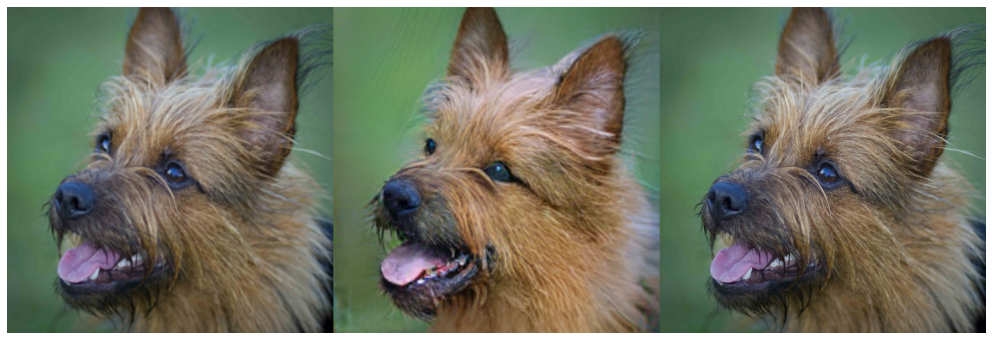

In [ ]:
visualize_images(np.vstack([ur_imgs, gen_images[0][None], hr_imgs]))